In [1]:
# importing the csv files
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import os
import random 
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tabulate import tabulate

os.environ['PYTHONHASHSEED']     = '0'
os.environ['TF_DETERMINISTIC_OPS']= '1'  
 
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

df_amazon = pd.read_csv('/kaggle/input/stockss/amazon_data.csv') 

2025-04-29 20:07:26.343617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745957246.562946      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745957246.618373      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# convert the "Date" column to a date and hour format with to_datetime() and creating separate columns
df_amazon['Date'] = pd.to_datetime(df_amazon['Date'])

df_amazon['date'] = df_amazon['Date'].dt.date
df_amazon['hour'] = df_amazon['Date'].dt.hour

df_amazon = df_amazon.drop(columns=['Date'])


#here I'm flipping the data so we don't need to read data from bottom up
df_amazon = df_amazon.iloc[::-1]
df_amazon = df_amazon.reset_index(drop=True)

# Create a final cleaned version w 
cleaned_amazon = df_amazon.drop(columns=['High', 'Low', 'Close'])
cleaned_amazon['Change'] = cleaned_amazon['Open'].shift(1) - cleaned_amazon['Open']
cleaned_amazon['Change'] = cleaned_amazon['Change'].fillna(0)
len(cleaned_amazon)

cleaned_amazon = cleaned_amazon[['date', 'hour', 'Open', 'Volume', 'Change']] # reording cols
print(cleaned_amazon) # the final version will be 'cleaned_amazon'


           date  hour    Open  Volume  Change
0    2024-09-18     9  186.50   91259    0.00
1    2024-09-18    10  186.58   91530   -0.08
2    2024-09-18    11  187.08   84873   -0.50
3    2024-09-18    12  185.75   48245    1.33
4    2024-09-18    13  186.65   57807   -0.90
..          ...   ...     ...     ...     ...
893  2025-03-14    11  197.57  175457   -1.03
894  2025-03-14    12  197.76  122777   -0.19
895  2025-03-14    13  198.15  107892   -0.39
896  2025-03-14    14  197.20  105407    0.95
897  2025-03-14    15  197.60  424006   -0.40

[898 rows x 5 columns]


I0000 00:00:1745957258.802094      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


2025-04-29 20:07:40.230256: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1745957262.404753      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2165 - mae: 0.2165 - val_loss: 0.0801 - val_mae: 0.0801
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0638 - val_mae: 0.0638
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0408 - val_mae: 0.0408
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0441 - val_mae: 0.0441
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0465 - val_mae: 0.0465
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0385 - val_mae: 0.0385
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0482 - val_mae: 0.0482
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0532 - val_mae: 0.0532
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0314 - mae: 0.

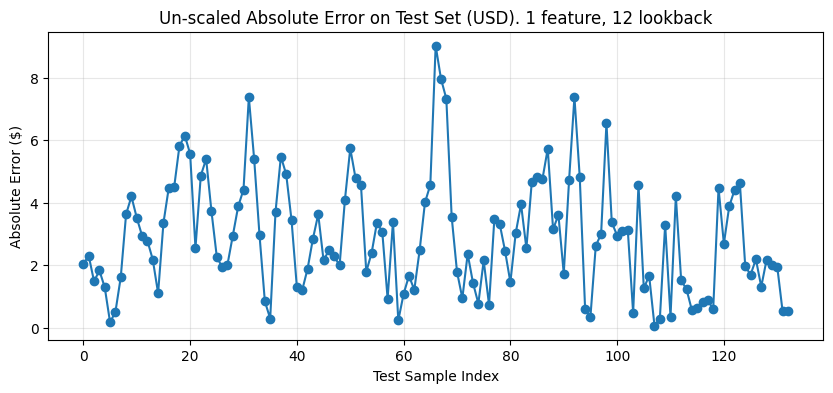

--- Test‐set results ---
      date  hour  actual_open  predicted_open  difference  abs_error
2025-02-19    10   224.949997      226.990005        2.04       2.04
2025-02-19    11   224.410004      226.710007        2.30       2.30
2025-02-19    12   224.960007      226.440002        1.48       1.48
2025-02-19    13   224.449997      226.279999        1.83       1.83
2025-02-19    14   224.830002      226.119995        1.29       1.29
2025-02-19    15   226.210007      226.039993       -0.17       0.17
2025-02-19    16   226.649994      226.149994       -0.50       0.50
2025-02-20     9   224.779999      226.389999        1.61       1.61
2025-02-20    10   222.850006      226.479996        3.63       3.63
2025-02-20    11   222.080002      226.279999        4.20       4.20
2025-02-20    12   222.369995      225.889999        3.52       3.52
2025-02-20    13   222.520004      225.460007        2.94       2.94
2025-02-20    14   222.270004      225.050003        2.78       2.78
2025-02-2

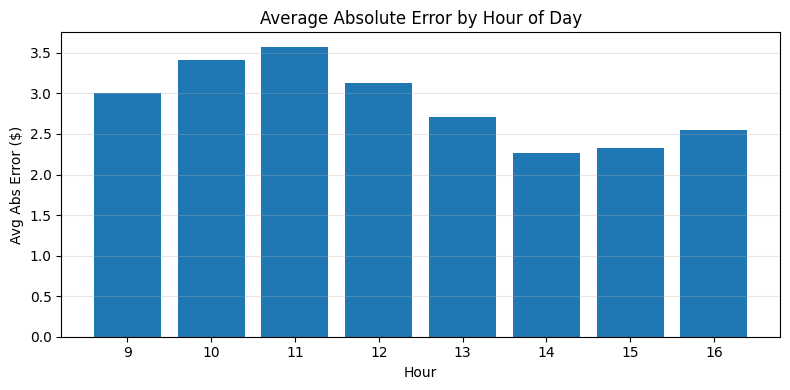

In [3]:
# ver 4 


series = cleaned_amazon[['Open']].values.astype('float32')

# 2) Scale to [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
series_scaled = scaler.fit_transform(series)

# 3) Turn into supervised learning: create sequences of length `look_back` to predict the next value 
# We use look back of 12 hours to predict the next hour's price
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

LOOK_BACK = 12
# Build the X/y arrays using LOOK_BACK=12
X, y = create_sequences(series_scaled, LOOK_BACK)

# Split into Train / Validation / Test
#    - Train on first 70% of the data
#    - Validate on the next 15%
#    - Test on the final 15%
n = len(X)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

X_train, y_train = X[:train_end],   y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:],     y[val_end:] # Test on the final 15%


# LSTM expects input shape of [samples, timesteps, features].
#    We use 1 feature for this version (the scaled Open price) and LOOK_BACK timesteps
X_train = X_train.reshape((-1, LOOK_BACK, 1))
X_val   = X_val.reshape((-1,   LOOK_BACK, 1))
X_test  = X_test.reshape((-1,  LOOK_BACK, 1))

# Build the Sequential LSTM Model
model = Sequential([ 
    LSTM(100, return_sequences=False, input_shape=(LOOK_BACK, 1)), # 100 units in the LSTM cell
    Dense(1) #  produce a single scalar—the next hour’s price
])
model.compile(
    optimizer='adam',
    loss='mae',# model works to minimize mean absolute error
    metrics=['mae']       
)

# Train with early stopping if validation loss doesn’t improve for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train, # training data
    validation_data=(X_val, y_val),  # validation data
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
) 
 
# Evaluate on the Test Set
#    - get scaled predictions
y_pred_scaled = model.predict(X_test) 

# invert scaling and compute MAE on test targets vs. test predictions
y_test_inv    = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv    = scaler.inverse_transform(y_pred_scaled).flatten()
 
real_mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test MAE (USD): {real_mae:.2f}")

 
# assemble DataFrame of results for analysis/plotting
start_idx = val_end + LOOK_BACK
end_idx   = start_idx + len(y_test_inv)

results = pd.DataFrame({
    'date'          : cleaned_amazon['date'].iloc[start_idx:end_idx].values,
    'hour'          : cleaned_amazon['hour'].iloc[start_idx:end_idx].values,
    'actual_open'   : y_test_inv,
    'predicted_open': y_pred_inv
})
results['difference'] = results['predicted_open'] - results['actual_open']
results['abs_error']  = results['difference'].abs()

# rounding below for organization 
results[['actual_open','predicted_open','difference','abs_error']] = \
    results[['actual_open','predicted_open','difference','abs_error']].round(2)

#  now we pot the mae on test set
plt.figure(figsize=(10,4))
plt.plot(results['abs_error'], marker='o')
plt.title('Un-scaled Absolute Error on Test Set (USD). 1 feature, 12 lookback')
plt.xlabel('Test Sample Index')
plt.ylabel('Absolute Error ($)')
plt.grid(alpha=0.3)
plt.show()

 
print("--- Test‐set results ---")
print(results.to_string(index=False))
 
predicted_prices_list = [round(x, 2) for x in results['predicted_open'].tolist()]
print("\nList of all rounded predicted prices:")
print(predicted_prices_list)

 
# Bar chart of average error by hour of day
hourly_err = results.groupby('hour')['abs_error'].mean()
plt.figure(figsize=(8,4))
plt.bar(hourly_err.index, hourly_err.values)
plt.title('Average Absolute Error by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Avg Abs Error ($)')
plt.xticks(hourly_err.index)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-29 20:07:45.429729: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2328 - mae: 0.2328 - val_loss: 0.1814 - val_mae: 0.1814
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0512 - mae: 0.0512 - val_loss: 0.0683 - val_mae: 0.0683
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0716 - val_mae: 0.0716
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0628 - val_mae: 0.0628
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0498 - val_mae: 0.0498
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0485 - val_mae: 0.0485
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0288 - mae: 0.

2025-04-29 20:07:52.223416: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Test MAE (USD): 1.58


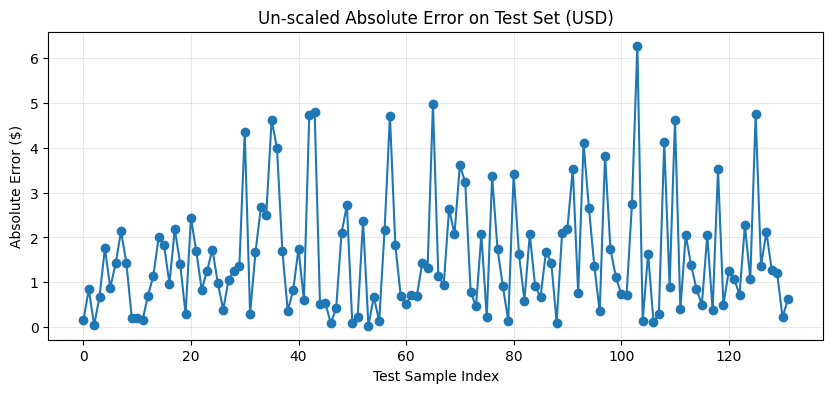

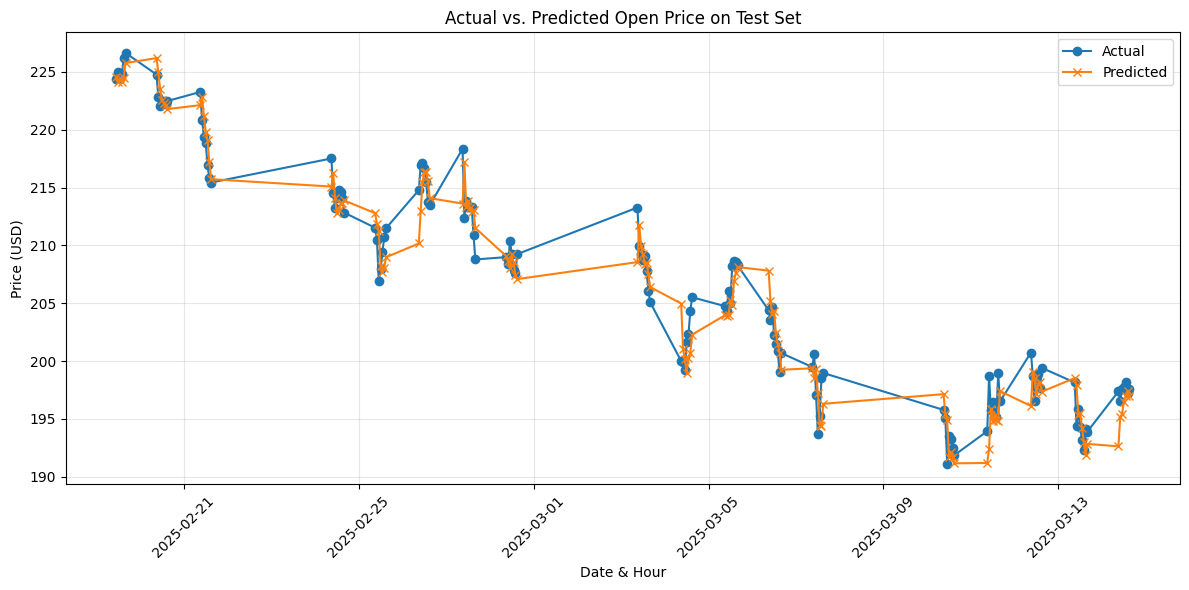

--- Test‐set results ---
      date  hour  actual_open  predicted_open  difference  abs_error
2025-02-19    11   224.410004      224.559998        0.15       0.15
2025-02-19    12   224.960007      224.119995       -0.84       0.84
2025-02-19    13   224.449997      224.490005        0.04       0.04
2025-02-19    14   224.830002      224.149994       -0.68       0.68
2025-02-19    15   226.210007      224.449997       -1.76       1.76
2025-02-19    16   226.649994      225.770004       -0.88       0.88
2025-02-20     9   224.779999      226.199997        1.42       1.42
2025-02-20    10   222.850006      224.990005        2.14       2.14
2025-02-20    11   222.080002      223.509995        1.43       1.43
2025-02-20    12   222.369995      222.570007        0.20       0.20
2025-02-20    13   222.520004      222.309998       -0.21       0.21
2025-02-20    14   222.270004      222.119995       -0.15       0.15
2025-02-20    15   222.490005      221.789993       -0.70       0.70
2025-02-2

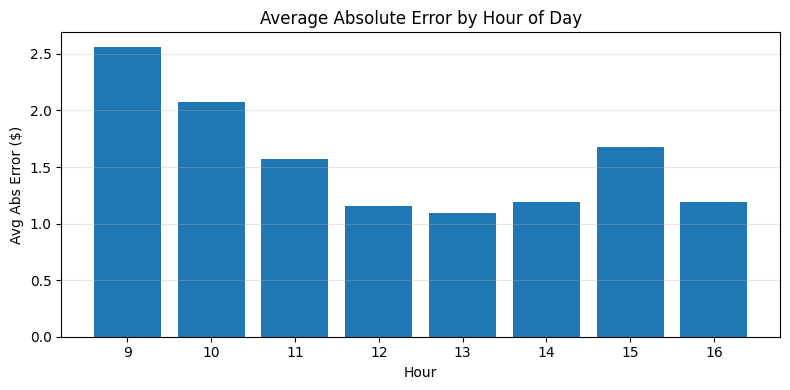

In [4]:
# ver 5 with 3 features
 
LOOK_BACK = 24
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15  

df = cleaned_amazon.copy()   

X_raw = df[['Open','Volume','Change']].values.astype('float32')
y_raw = df[['Open']].values.astype('float32')  
 
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)
 
def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i : i + look_back])          
        ys.append(y[i + look_back, 0])          
    return np.array(Xs), np.array(ys)

X, y = create_sequences(X_scaled, y_scaled, LOOK_BACK)

n = len(X)
train_end = int(n * TRAIN_RATIO)
val_end   = int(n * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X[:train_end],          y[:train_end]
X_val,   y_val   = X[train_end:val_end],   y[train_end:val_end]
X_test,  y_test  = X[val_end:],            y[val_end:]

 
 
n_features = X.shape[2]  # = 3
model = Sequential([
    LSTM(100, input_shape=(LOOK_BACK, n_features)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

 
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)
 
test_loss, test_scaled_mae = model.evaluate(
    X_test, y_test,
    batch_size=32,
    verbose=1   
)
print(f"Test MSE (scaled): {test_loss:.4f}")
print(f"Test MAE (scaled): {test_scaled_mae:.4f}")
 
y_pred_scaled = model.predict(X_test)
y_test_inv    = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv    = scaler_y.inverse_transform(y_pred_scaled).flatten()

real_mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test MAE (USD): {real_mae:.2f}")
 
start_idx = val_end + LOOK_BACK
end_idx   = start_idx + len(y_test_inv)

results = pd.DataFrame({
    'date'          : df['date'].iloc[start_idx:end_idx].values,
    'hour'          : df['hour'].iloc[start_idx:end_idx].values,
    'actual_open'   : y_test_inv,
    'predicted_open': y_pred_inv
})
results['difference'] = results['predicted_open'] - results['actual_open']
results['abs_error']  = results['difference'].abs()

# Round for neatness
results[['actual_open','predicted_open','difference','abs_error']] = \
    results[['actual_open','predicted_open','difference','abs_error']].round(2)

  
times = pd.to_datetime(
    results['date'].astype(str) + ' ' +
    results['hour'].astype(str) + ':00'
)
#  plot it
plt.figure(figsize=(10,4))
plt.plot(results['abs_error'], marker='o')
plt.title('Un-scaled Absolute Error on Test Set (USD)')
plt.xlabel('Test Sample Index')
plt.ylabel('Absolute Error ($)')
plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(12,6))
plt.plot(times, results['actual_open'],    marker='o', label='Actual')
plt.plot(times, results['predicted_open'], marker='x', label='Predicted')
plt.title('Actual vs. Predicted Open Price on Test Set')
plt.xlabel('Date & Hour')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

 
hourly_err = results.groupby('hour')['abs_error'].mean()
plt.figure(figsize=(8,4))
plt.bar(hourly_err.index, hourly_err.values)
plt.title('Average Absolute Error by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Avg Abs Error ($)')
plt.xticks(hourly_err.index)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
 
print("--- Test‐set results ---")
print(results.to_string(index=False))
 
predicted_prices_list = [round(x, 2) for x in results['predicted_open'].tolist()]
print("\nList of all rounded predicted prices:")
print(predicted_prices_list)


In [5]:
# ver 5 comparisons
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
 
look_backs = [6, 12, 24, 48]
units_list = [50, 100]

 
TRAIN_RATIO, VAL_RATIO = 0.70, 0.15

results = []

for LOOK_BACK in look_backs: 
    X_raw = df[['Open','Volume','Change']].values.astype('float32')
    y_raw = df[['Open']].values.astype('float32')
    scaler_X = MinMaxScaler(); scaler_y = MinMaxScaler()
    Xs = scaler_X.fit_transform(X_raw)
    ys = scaler_y.fit_transform(y_raw)
    
    def create_sequences(X, y, lb):
        Xs, ys_ = [], []
        for i in range(len(X) - lb):
            Xs.append(X[i:i+lb])
            ys_.append(y[i+lb, 0])
        return np.array(Xs), np.array(ys_)
    
    X, y = create_sequences(Xs, ys, LOOK_BACK)
    
    # 2) Split
    n = len(X)
    train_end = int(n * TRAIN_RATIO)
    val_end   = int(n * (TRAIN_RATIO + VAL_RATIO))
    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]
    
    for units in units_list:
        # 3) Build & train
        model = Sequential([
            LSTM(units, input_shape=(LOOK_BACK, X.shape[2])),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mae')
        es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100, batch_size=32,
            callbacks=[es], verbose=0
        )
        
        # 4) Evaluate & invert
        # a) on test split
        y_pred_scaled = model.predict(X_test)
        y_test_inv    = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
        y_pred_inv    = scaler_y.inverse_transform(y_pred_scaled).flatten()
         
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        diffs = y_pred_inv - y_test_inv
        
        results.append({
            'look_back': LOOK_BACK,
            'units':     units,
            'Test MAE (USD)':   mae,
            'Mean Diff (USD)':   diffs.mean(),
            'Mean Abs Err (USD)': diffs.mean(axis=0, keepdims=False) if False else mae,
            'Test RMSE (USD)':  rmse
        })
 
df_results = pd.DataFrame(results)
print("\nHyperparameter comparison results:\n")
print(df_results.to_string(index=False))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step

2025-04-29 20:07:57.776474: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-29 20:08:03.585545: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

2025-04-29 20:08:09.241015: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-29 20:08:14.677486: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step

2025-04-29 20:08:21.744695: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step

2025-04-29 20:08:29.087849: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-29 20:08:38.664792: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Hyperparameter comparison results:

 look_back  units  Test MAE (USD)  Mean Diff (USD)  Mean Abs Err (USD)  Test RMSE (USD)
         6     50        2.078687         0.582559            2.078687         2.621048
         6    100        2.467907         1.206974            2.467907         3.035455
        12     50        1.501390         0.303897            1.501390         1.921019
        12    100        3.210626         2.468670            3.210626         3.946667
        24     50        1.489744        -0.227355            1.489744         1.964406
        24    100        1.540310         0.534545            1.540310         1.973648
        48     50        1.681047         0.751957            1.681047         2.111865
        48    100        1.554974         0.157561            1.554974         1.990362


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-29 20:08:45.812148: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2508 - mae: 0.2508 - val_loss: 0.1749 - val_mae: 0.1749
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0746 - mae: 0.0746 - val_loss: 0.0541 - val_mae: 0.0541
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0401 - mae: 0.0401 - val_loss: 0.0428 - val_mae: 0.0428
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0427 - val_mae: 0.0427
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0447 - val_mae: 0.0447
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282 - mae: 0.

2025-04-29 20:08:55.373673: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Test MAE (USD): 1.49


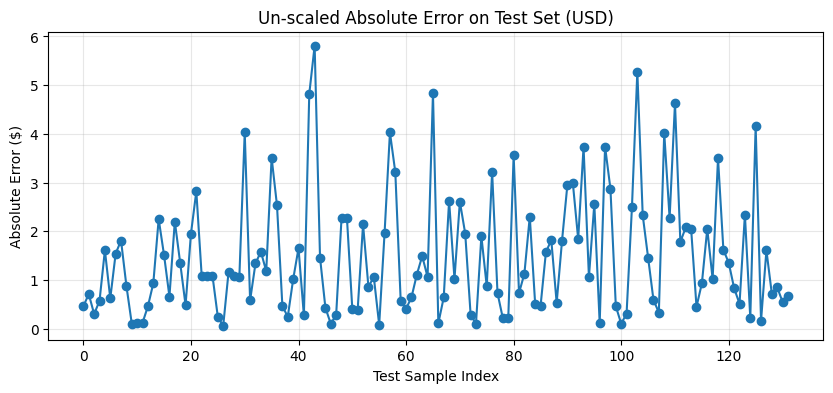

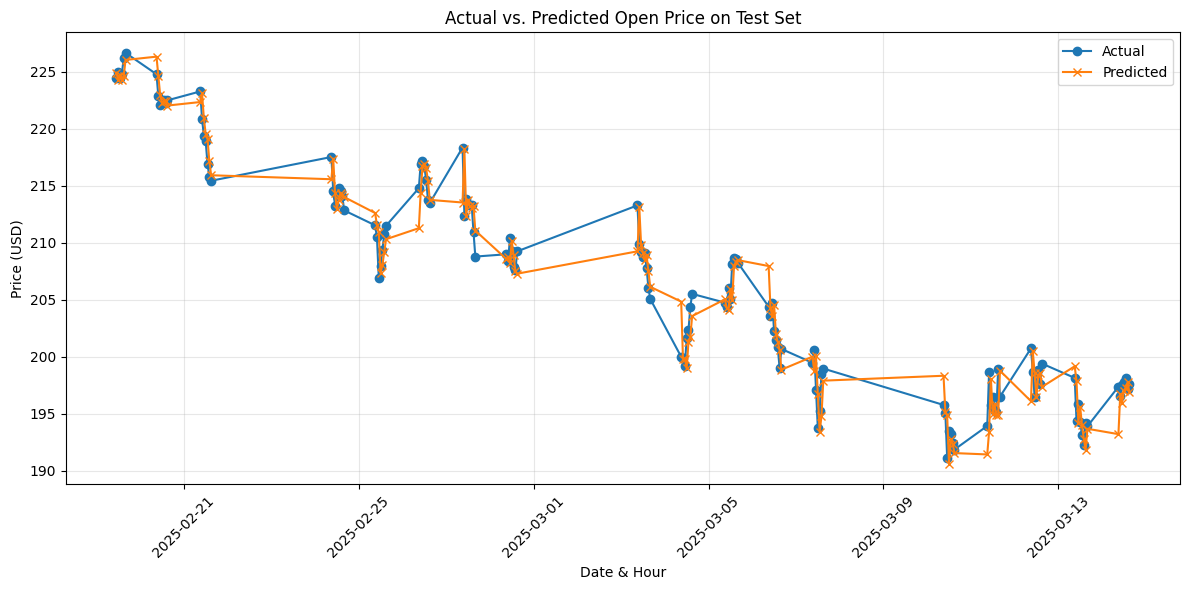

+------------+--------+------------------+---------------+--------------+
| date       |   hour |   predicted_open |   actual_open |   difference |
|------------+--------+------------------+---------------+--------------|
| 2025-02-19 |     11 |           224.87 |        224.41 |         0.46 |
| 2025-02-19 |     12 |           224.25 |        224.96 |        -0.71 |
| 2025-02-19 |     13 |           224.75 |        224.45 |         0.3  |
| 2025-02-19 |     14 |           224.26 |        224.83 |        -0.57 |
| 2025-02-19 |     15 |           224.6  |        226.21 |        -1.61 |
| 2025-02-19 |     16 |           226.03 |        226.65 |        -0.62 |
| 2025-02-20 |      9 |           226.32 |        224.78 |         1.54 |
| 2025-02-20 |     10 |           224.66 |        222.85 |         1.81 |
| 2025-02-20 |     11 |           222.96 |        222.08 |         0.88 |
| 2025-02-20 |     12 |           222.27 |        222.37 |        -0.1  |
| 2025-02-20 |     13 |           222.

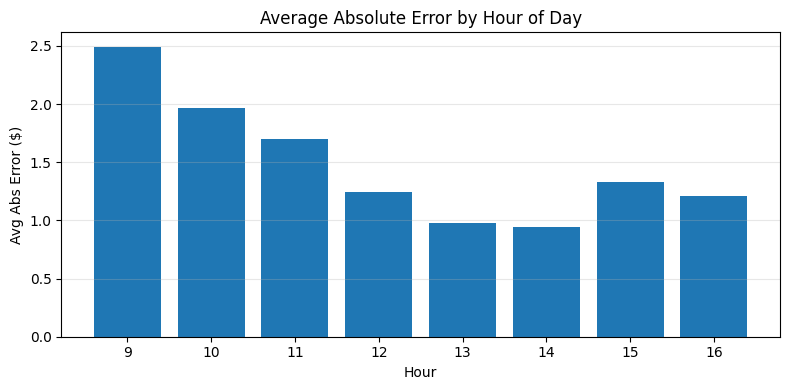

In [6]:
# ver 5
 
LOOK_BACK = 24
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15  

df = cleaned_amazon.copy()   

X_raw = df[['Open','Volume','Change']].values.astype('float32')
y_raw = df[['Open']].values.astype('float32')  
 
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)
 
def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i : i + look_back])          
        ys.append(y[i + look_back, 0])          
    return np.array(Xs), np.array(ys)

X, y = create_sequences(X_scaled, y_scaled, LOOK_BACK)

n = len(X)
train_end = int(n * TRAIN_RATIO)
val_end   = int(n * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X[:train_end],          y[:train_end]
X_val,   y_val   = X[train_end:val_end],   y[train_end:val_end]
X_test,  y_test  = X[val_end:],            y[val_end:]

 
 
n_features = X.shape[2]  # = 3
model = Sequential([
    LSTM(50, input_shape=(LOOK_BACK, n_features)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

 
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)
 
test_loss, test_scaled_mae = model.evaluate(
    X_test, y_test,
    batch_size=32,
    verbose=1   
)
print(f"Test MSE (scaled): {test_loss:.4f}")
print(f"Test MAE (scaled): {test_scaled_mae:.4f}")
 
y_pred_scaled = model.predict(X_test)
y_test_inv    = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv    = scaler_y.inverse_transform(y_pred_scaled).flatten()

real_mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test MAE (USD): {real_mae:.2f}")
 
start_idx = val_end + LOOK_BACK
end_idx   = start_idx + len(y_test_inv)

results = pd.DataFrame({
    'date'          : df['date'].iloc[start_idx:end_idx].values,
    'hour'          : df['hour'].iloc[start_idx:end_idx].values,
    'actual_open'   : y_test_inv,
    'predicted_open': y_pred_inv
})
results['difference'] = results['predicted_open'] - results['actual_open']
results['abs_error']  = results['difference'].abs()

# Round for neatness
results[['actual_open','predicted_open','difference','abs_error']] = \
    results[['actual_open','predicted_open','difference','abs_error']].round(2)

  
times = pd.to_datetime(
    results['date'].astype(str) + ' ' +
    results['hour'].astype(str) + ':00'
)
#  plot it
plt.figure(figsize=(10,4))
plt.plot(results['abs_error'], marker='o')
plt.title('Un-scaled Absolute Error on Test Set (USD)')
plt.xlabel('Test Sample Index')
plt.ylabel('Absolute Error ($)')
plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(12,6))
plt.plot(times, results['actual_open'],    marker='o', label='Actual')
plt.plot(times, results['predicted_open'], marker='x', label='Predicted')
plt.title('Actual vs. Predicted Open Price on Test Set')
plt.xlabel('Date & Hour')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

 
hourly_err = results.groupby('hour')['abs_error'].mean()
plt.figure(figsize=(8,4))
plt.bar(hourly_err.index, hourly_err.values)
plt.title('Average Absolute Error by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Avg Abs Error ($)')
plt.xticks(hourly_err.index)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


print(
    tabulate(
        results[['date', 'hour', 'predicted_open', 'actual_open', 'difference']],
        headers='keys',
        tablefmt='psql',
        showindex=False
    )
)

 
 


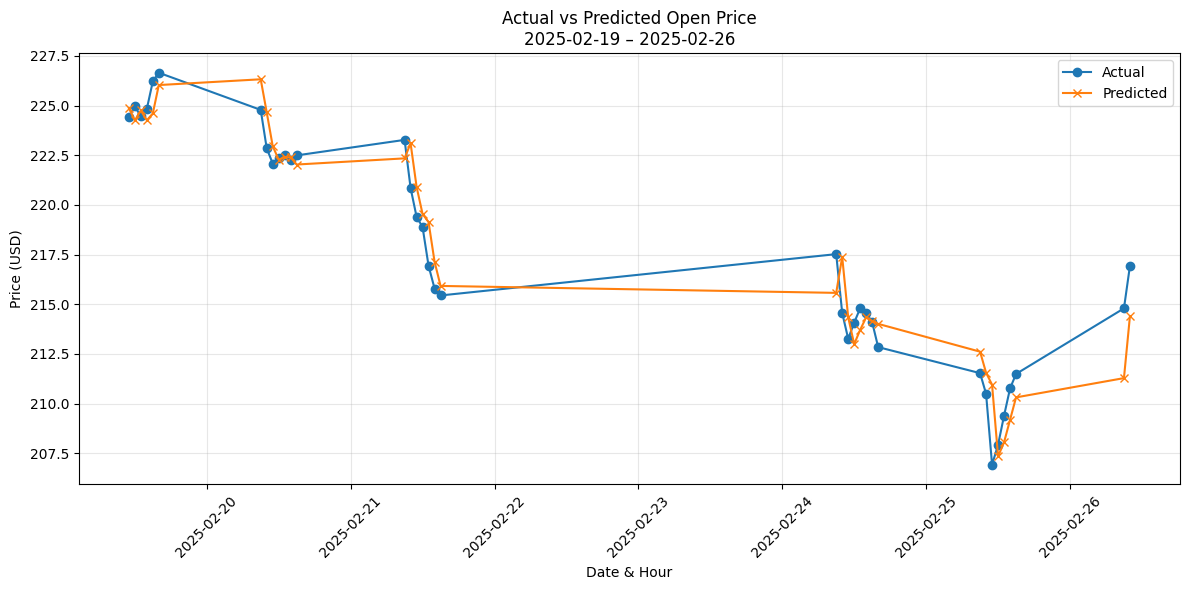

In [7]:
import pandas as pd
import matplotlib.pyplot as plt 
results['time'] = pd.to_datetime(
    results['date'].astype(str) + ' ' +
    results['hour'].astype(str) + ':00'
)

#  (first week of test set)
start = results['time'].min()
end   = start + pd.Timedelta(days=7)
 
week_data = results[(results['time'] >= start) & (results['time'] < end)]

# Plot actual vs. predicted
plt.figure(figsize=(12,6))
plt.plot(week_data['time'], week_data['actual_open'],    marker='o', label='Actual')
plt.plot(week_data['time'], week_data['predicted_open'], marker='x', label='Predicted')
plt.title(f'Actual vs Predicted Open Price\n{start.date()} – {end.date()}')
plt.xlabel('Date & Hour')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()